In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels.api as sm
import pickle
import json
from typing import List,Dict,Tuple,Union
from scipy.stats import ttest_ind


In [58]:
susp_df  = pd.read_excel('Susp_Cond_1_1st_May_25/Suspense_rating/final_susp_overall.xlsx')
trials_df = pd.read_excel("stimuli_29Apr24_5_trials.xlsx")

suspense_sum = pd.read_excel('suspense_sum.xlsx')


In [59]:
grouped_df = susp_df.groupby(by=['game','participant'], as_index=False)

full_dataframe = pd.DataFrame()

for meta, dataframe in grouped_df: 
    dataframe.sort_values(by='pair_number', ascending=True, inplace = True)
    dataframe['count'] = dataframe['card_1'].cumsum()
    full_dataframe = pd.concat([full_dataframe, dataframe])
susp_df = full_dataframe.copy()


In [60]:
len(susp_df['participant'].unique())

21

### Exclude bad particants with catch trial results

First, we have to re-integrate the pseudo-randomisation by game in the overall_df as the data is extracted without it

- Game 0: 1-1-1-2-2
- Game 1: 1-1-2-2-1
- Game 3: 2-2-2-1-1

- Game 7: 1-1-2-2-1
- Game 9: 2-2-2-1-1
- Game 11: 2-1-1-2-1

- Game 12: 1-1-1-2-2
- Game 14: 1-2-21-2
- Game 15: 2-2-2-1-1
- Game 16: 2-2-1-1-2

- Game 19: 1-1-2-2-1
- Game 20: 1-2-2-1-2
- Game 22: 2-2-1-1-2

- Game 25: 1-1-2-2-1
- Game 28: 2-2-1-1-2
- Game 29: 2-1-1-2-1

- Game 32: 1-2-2-1-2
- Game 33: 2-2-2-1-1
- Game 34: 2-2-1-1-2

In [61]:
#sort overall dataframe by game
susp_df.sort_values(by="game",ascending=True)


,rt,catch_response,susp_rating,trial,game,pair_number,card_1,card_2,count,expected_outcome,suspense_level,participant
0,7438,1,-0.946903,0,0,1,-6,1,-6,winning,low suspense,Participant1
311,1887,1,0.789782,8,0,2,1,-4,-5,winning,low suspense,Participant4
310,1980,0,-1.619797,8,0,1,-6,1,-6,winning,low suspense,Participant4
224,5942,0,0.071709,8,0,5,-4,1,-17,winning,low suspense,Participant3
223,3342,0,-0.219730,8,0,4,-3,1,-13,winning,low suspense,Participant3
...,...,...,...,...,...,...,...,...,...,...,...,...
1239,3222,1,0.378675,13,34,5,1,-3,4,losing,high suspense,Participant14
1238,1701,1,0.547370,13,34,4,-1,3,3,losing,high suspense,Participant14
1237,806,0,0.167807,13,34,3,5,-3,4,losing,high suspense,Participant14
1154,3174,1,1.618450,14,34,5,1,-3,4,losing,high suspense,Participant13


In [62]:
susp_df[susp_df['participant'] == 'Participant1']['susp_rating'].mean()


0.024019846290244295

In [63]:
#Write function to swap cards when required accoding to game index

def number_to_ordering(number:int)->Tuple[str,str]:
    """If the number is 1, then we have the normal order (i.e. no swapping), else we reverse the columns."""
    match number:
        case 1:
            return ("card_1","card_2")
        case 2:
            return ("card_2","card_1")


def swap_cards_mod(results_dataframe:pd.DataFrame,trials_dataframe:pd.DataFrame )->pd.DataFrame:
    
    # Getting the unique games from the dataframe
    unique_games:List[int]= list(results_dataframe["game"].unique())
    
    full_data:pd.DataFrame = pd.DataFrame()
    # Iterating through the games to make choices on how to set the card choice
    for game_number in unique_games:
        # Card rules are given by the randomisation string in the trials dataframe
        randomisation_string:str = trials_dataframe.iloc[game_number]["Randomisation"]
        position_choices:List[int] = [ int(part) for part in randomisation_string if part.isnumeric()]
        
        # Adding index to the position
        position_choices:List[Tuple[int,int]] = [(iter+1 ,part) for iter,part in enumerate(position_choices)]

        # Making a copy of the data to amend to concat later
        subset_dataframe:pd.DataFrame = results_dataframe.loc[results_dataframe["game"] == game_number].copy()
        
        # Generating the conditons for the numpy select
        for pair_num, card_choice in position_choices:
            # Making a copy of the subset so we don't override
            subset_copy = subset_dataframe.copy()


            orderings:Tuple[str,str] = number_to_ordering(card_choice)

            # creating conditions for the numpy select
            swap_conditions:List[bool]= [subset_dataframe["pair_number"] == pair_num]
            swap_cond_copy:List[bool] = [subset_copy["pair_number"] == pair_num]

            # Using numpy select to perform the swap on the data.
            subset_dataframe["card_1"] = np.select(swap_conditions,[subset_dataframe[orderings[0]]],default = subset_dataframe["card_1"])
            subset_copy["card_2"] = np.select(swap_cond_copy,[subset_copy[orderings[1]]],default = subset_copy["card_2"])

            # Re-writing back
            subset_dataframe["card_2"] = subset_copy["card_2"]

        # Dataframe should now be altered, so we concatenate
        full_data = pd.concat([full_data,subset_dataframe])

    return full_data


def swap_cards(dataframe):

    swapped_df = dataframe.copy()

    for game in swapped_df ['game']:
        
        if game in [0, 6, 12]:
            for swapped_df ['pair_number'] in [4, 5]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [1, 7, 13]:
            for swapped_df ['pair_number'] in [3, 4]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [2, 8, 14]:
            for swapped_df ['pair_number'] in [2, 3]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']

        if game in [3, 9, 15]:
            for swapped_df ['pair_number'] in [1, 2, 3]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']

    
        if game in [4, 10, 16]:
            for swapped_df ['pair_number'] in [1, 2, 5]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [5, 11, 17]:
            for swapped_df ['pair_number'] in [1, 4]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
    return swapped_df




In [64]:
#swapped dataframe has all the cards randomised according to pseudo-randomisation
swapped_df = swap_cards_mod(susp_df,trials_df)


### Calculate participant accuracy


In [65]:

def catch_test(dataframe):
    success_rates = []
    filtered_dataframes = []

    for participant in dataframe['participant'].unique():
        # Filter dataframe for the current participant and make a copy
        participant_df = dataframe[dataframe['participant'] == participant].copy()

        # Calculate conditions
        condition_1 = (participant_df['card_1'] > 0) & (participant_df['card_2'] < 0) & (participant_df['catch_response'] == 0)
        condition_2 = (participant_df['card_1'] < 0) & (participant_df['card_2'] > 0) & (participant_df['catch_response'] == 1)
        condition_3 = (participant_df['card_1'] > 0) & (participant_df['card_2'] > 0) & (participant_df['catch_response'] == 2)
        condition_4 = (participant_df['card_1'] < 0) & (participant_df['card_2'] < 0) & (participant_df['catch_response'] == 3)

        # Concatenate conditions using logical OR
        result_array = condition_1 | condition_2 | condition_3 | condition_4

        # Calculate success rate for the participant
        true_count = result_array.sum()
        success_rate = (true_count / len(participant_df)) * 100
        success_rates.append(success_rate)

        # Add success rates to the dataframe
        participant_df.loc[:, 'success_rate'] = success_rate

        # Exclude participants with success rate lower than 70%
        if success_rate >= 75:
            filtered_dataframes.append(participant_df)

    # Concatenate all filtered dataframes into a single dataframe
    filtered_dataframe = pd.concat(filtered_dataframes)

    return filtered_dataframe


In [66]:
#Return filtered dataframe with only good participants

susp_filtered_df = catch_test(swapped_df)
len(susp_filtered_df['participant'].unique())



17

In [67]:
susp_filtered_df.to_excel('susp_filtered_df_1st.xlsx', index=False)

### Suspense per game according to participants

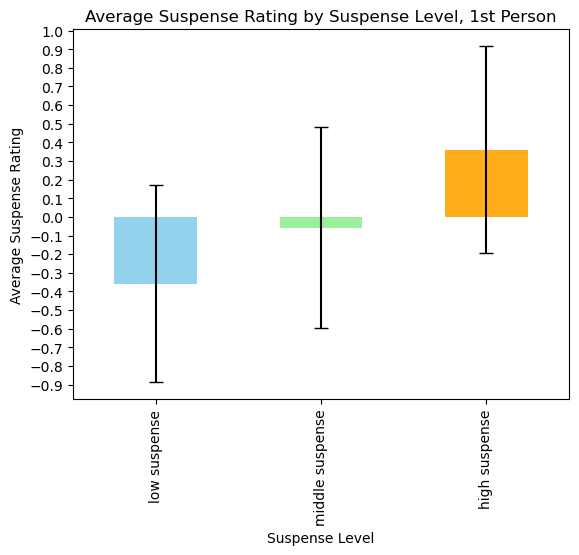

In [68]:
grouped_susp = susp_filtered_df.groupby(['suspense_level'])['susp_rating'].mean().sort_values()

grouped_se = susp_filtered_df.groupby(['suspense_level'])['susp_rating'].std()/np.sqrt(len(grouped_susp))

#make sure order is low, mid, high
grouped_se = grouped_se.reindex(['low suspense', 'middle suspense', 'high suspense'])
grouped_susp = grouped_susp.reindex(['low suspense', 'middle suspense', 'high suspense'])



# Plotting the bar plot with error bars as standard error (SEM)
ax = grouped_susp.plot(kind='bar', yerr=grouped_se, capsize=5, color=['skyblue', 'lightgreen', 'orange'], alpha=0.9)


plt.locator_params(axis='y', nbins=20) 

# Adding labels and title
plt.xlabel('Suspense Level')
plt.ylabel('Average Suspense Rating')
plt.title('Average Suspense Rating by Suspense Level, 1st Person')

# Show the plot
plt.show()

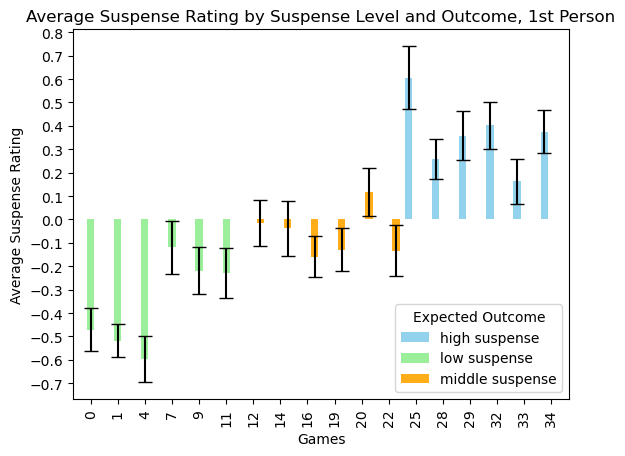

In [69]:
# Group the data by 'game' and 'suspense_level' and calculate the mean and SEM
grouped_susp = susp_filtered_df.groupby(['game', 'suspense_level'])['susp_rating'].mean().reset_index()
grouped_se = susp_filtered_df.groupby(['game', 'suspense_level'])['susp_rating'].std().reset_index()

# Compute count for each group
grouped_se['susp_rating'] = grouped_se['susp_rating'] / np.sqrt(susp_filtered_df.groupby(['game', 'suspense_level'])['susp_rating'].count().values)

# Create pivot tables for mean and standard error
grouped_df_mean = grouped_susp.pivot(index='game', columns='suspense_level', values='susp_rating')
grouped_df_sem = grouped_se.pivot(index='game', columns='suspense_level', values='susp_rating')

# Plotting the bar plot with error bars as standard error (SEM)
ax = grouped_df_mean.plot(kind='bar', yerr=grouped_df_sem, capsize=5, color=['skyblue', 'lightgreen', 'orange'], alpha=0.9, width=0.8)

# Customize the plot
plt.locator_params(axis='y', nbins=20)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Adding labels and title
ax.set_xlabel('Games')
ax.set_ylabel('Average Suspense Rating')
ax.set_title('Average Suspense Rating by Suspense Level and Outcome, 1st Person')

# Show the plot
plt.legend(title='Expected Outcome', loc='lower right')
plt.show()


### Compare subjective suspense ratings to model predictions

In [70]:
# Load the data from the pickle file
bestbin, gmbins = pickle.load(open('finalstim_Apr29_24_5_trials_small.p', 'rb'))

In [71]:
manual_group_k = [0, 1, 4, 1, 3, 5, 0, 2, 4, 0, 2, 4, 1, 4, 5, 2, 3, 4]

In [72]:
def extract_susp_points(manual_group_k): 


    k_range = manual_group_k
    number_of_experiments:int = int(len(k_range)/3)

    # Separating ther list into subsections
    experiment_division = [k_range[3*iter:3*iter+3] for iter in range(number_of_experiments)]


    group_susp = []
    group_pairs = []

    win_count = 0
    type_count = 0
    for game_choices in experiment_division:
        subset_games = [bestbin[type_count][win_count][game] for game in game_choices]
        game_susp = [game['suscpr']['L1'] for game in subset_games]
        pairs = [game['pairseq'] for game in subset_games]
        group_susp.extend(game_susp)
        group_pairs.extend(pairs)
        if win_count == 0:
            win_count +=1 
            continue
        elif win_count == 1:
            win_count = 0
            type_count +=1 
            continue

    return group_susp, group_pairs

In [73]:
model_susp, pairs = extract_susp_points(manual_group_k)

In [74]:
model_susp

[[0.007199999999999651, 0.0, 0.0, 0.0, 0],
 [0.011499999999999955, 0.0589999999999995, 0.009999999999999565, 0.0, 0],
 [0.024800000000000044, 0.0, 0.009999999999999565, 0.0, 0],
 [0.0388, 0.039000000000000035, 0.01999999999999999, 0.0, 0],
 [0.0, 0.024, 0.060000000000000005, 0.0, 0],
 [0.04500000000000001, 0.0, 0.0, 0.0, 0],
 [0.20650000000000002, 0.2250000000000001, 0.3300000000000003, 0.0, 0],
 [0.08870000000000011, 0.2140000000000002, 0.4900000000000001, 0.0, 0],
 [0.32080000000000003, 0.20200000000000018, 0.16000000000000014, 0.0, 0],
 [0.24080000000000001, 0.37400000000000033, 0.060000000000000005, 0.1, 0],
 [0.14259999999999995,
  0.2540000000000001,
  0.05000000000000002,
  0.30000000000000004,
  0],
 [0.10920000000000007,
  0.17600000000000005,
  0.21000000000000002,
  0.29999999999999993,
  0],
 [0.4736000000000001,
  0.15400000000000014,
  0.5000000000000002,
  0.19999999999999996,
  1],
 [0.5837000000000003,
  0.19100000000000017,
  0.13000000000000012,
  0.3999999999999999,

In [75]:
#Zscore model
model_susp_array = np.array(model_susp)
model_susp_flat = model_susp_array.flatten()

#Calculate mean and sd
mean = np.mean(model_susp_flat)
std = np.std(model_susp_flat)

#Calculate z-scored normalisation
model_susp_zscored = (model_susp_flat - mean)/std

#Reshape model to get original array form

model_susp_zscored = model_susp_zscored.reshape(model_susp_array.shape)



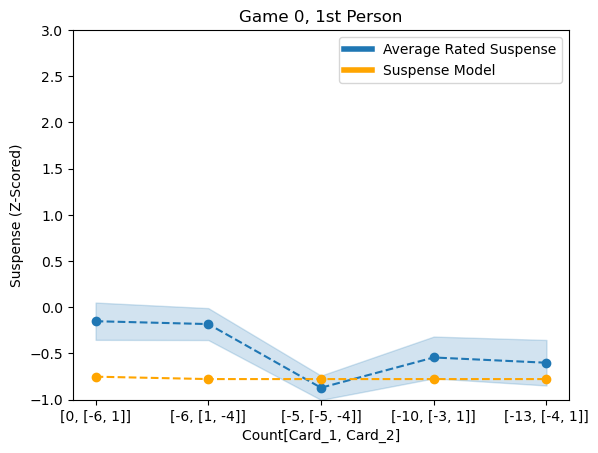

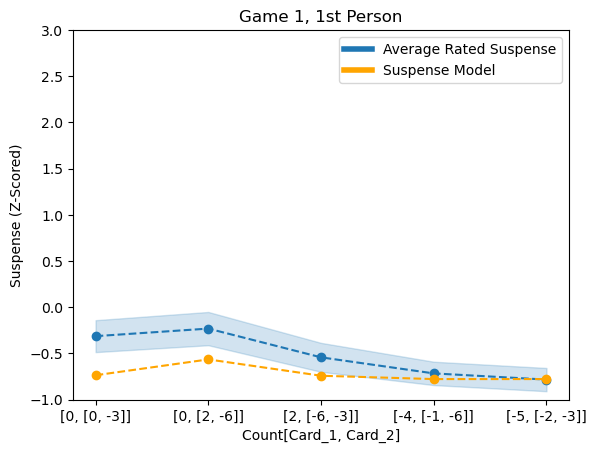

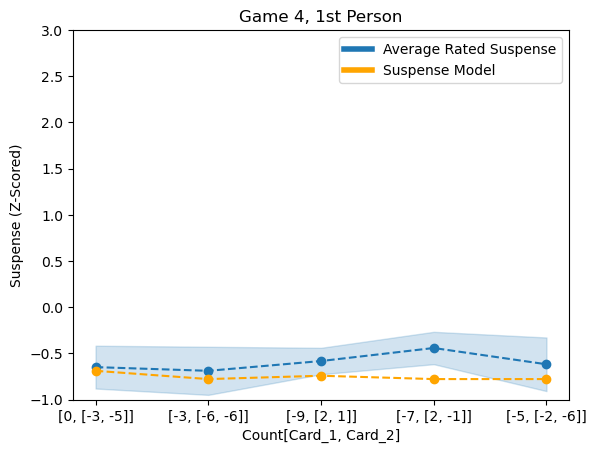

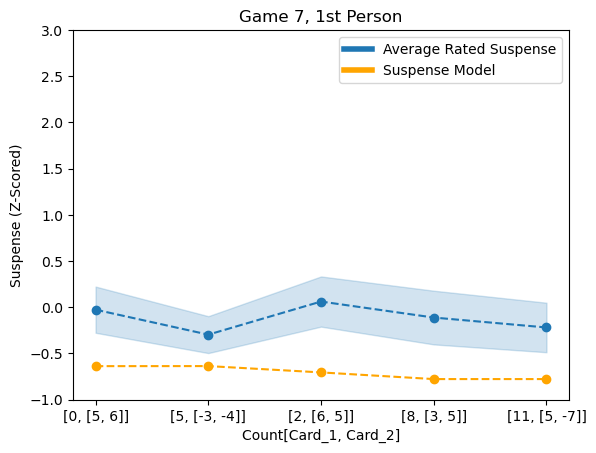

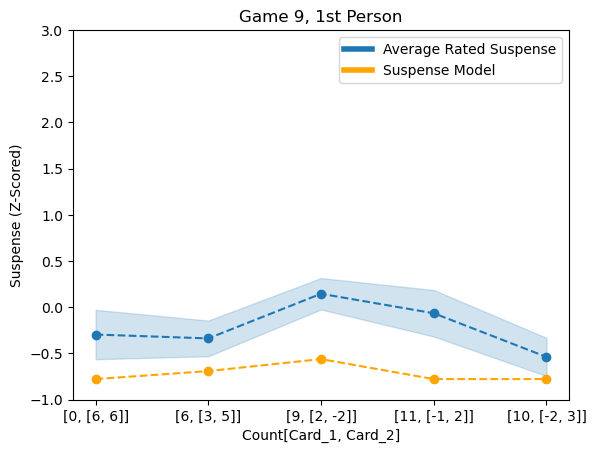

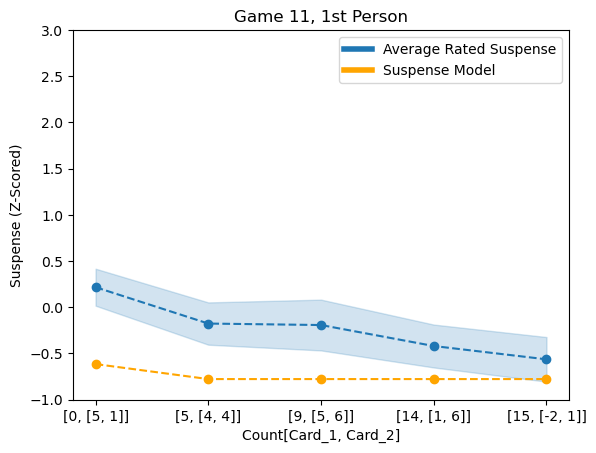

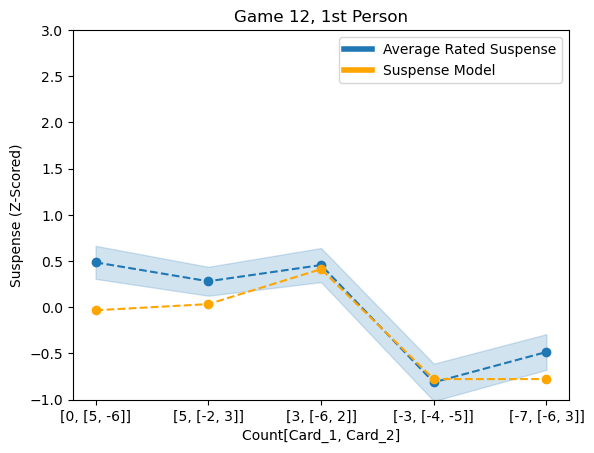

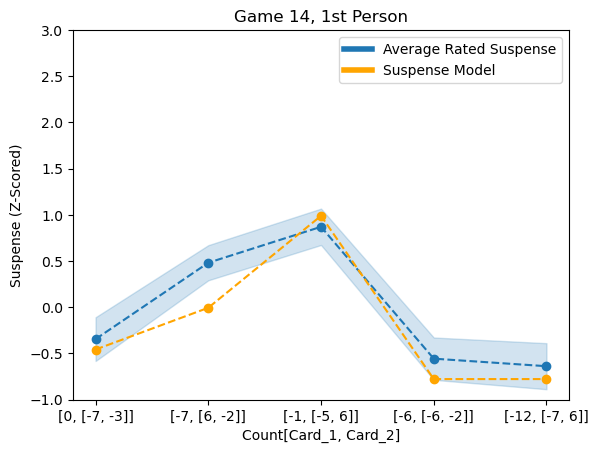

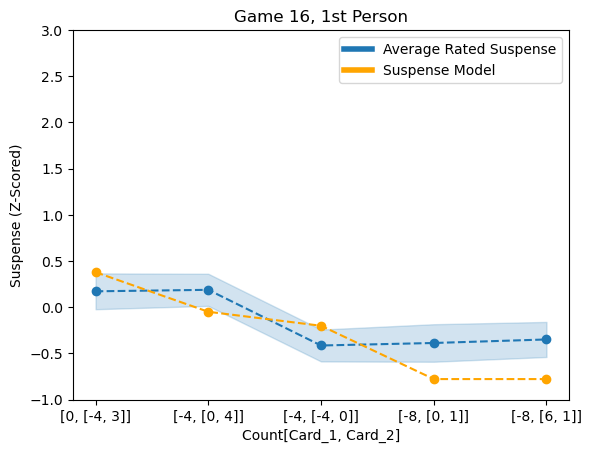

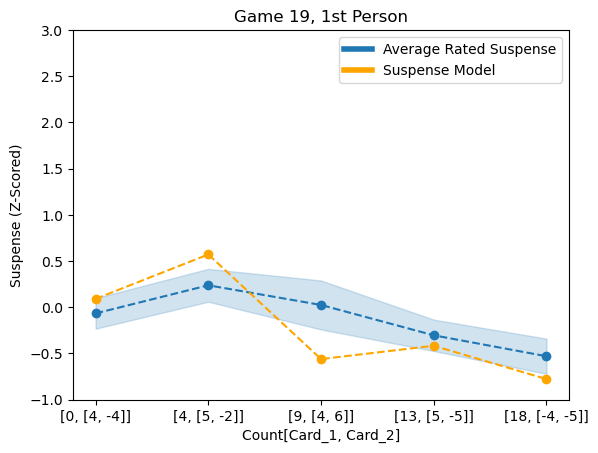

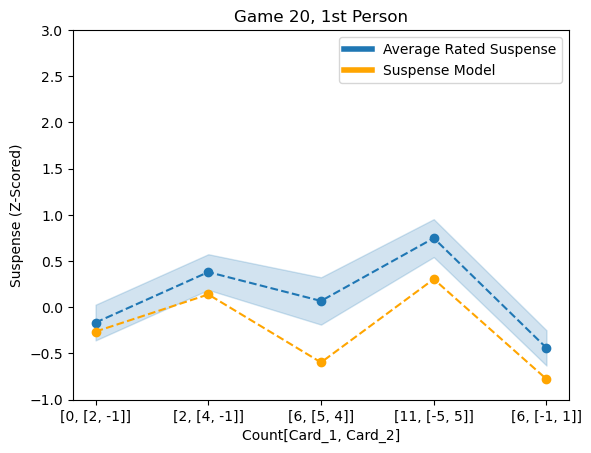

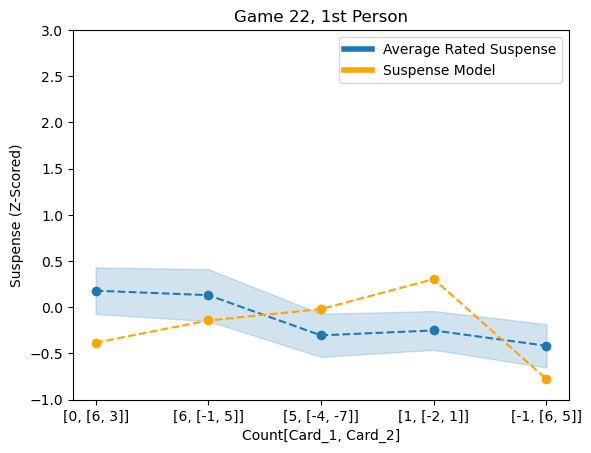

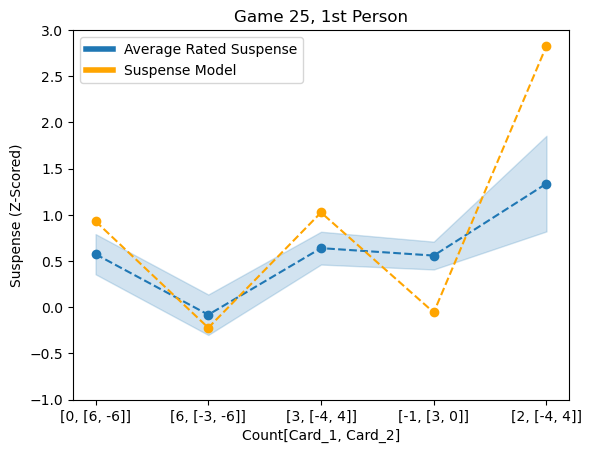

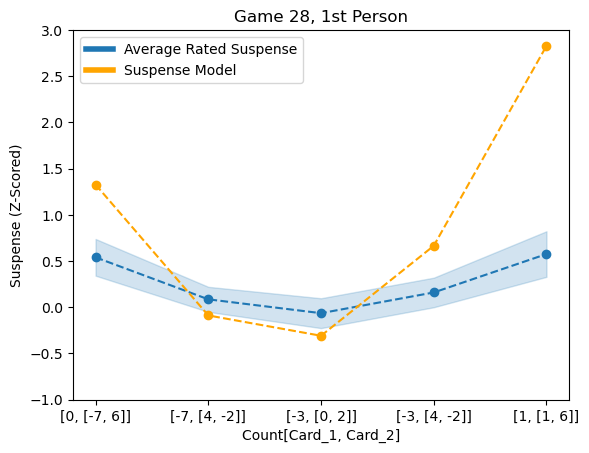

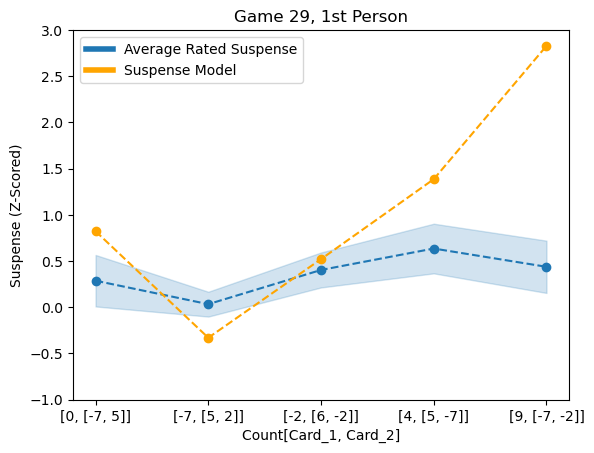

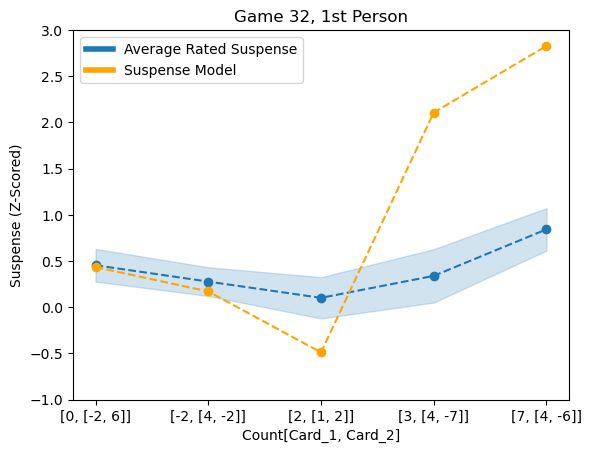

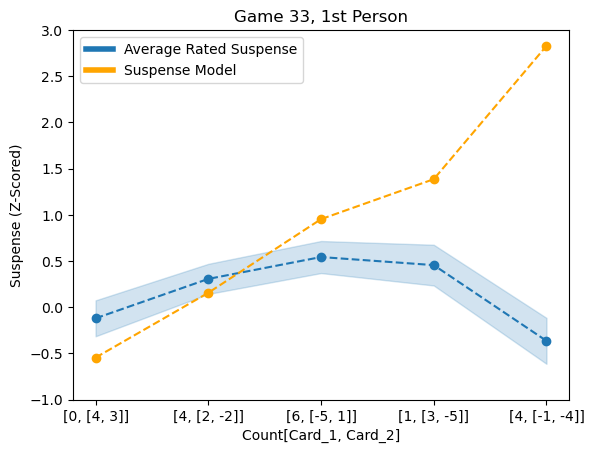

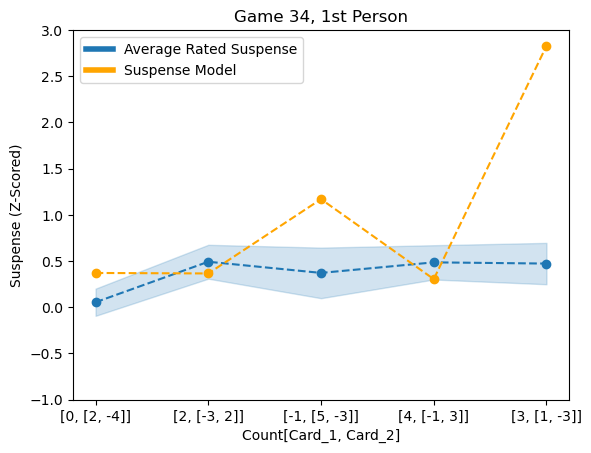

In [76]:
#plot the average suspense per round per game across participants

grouped_mean_susp = susp_filtered_df.groupby(['game', 'pair_number'])['susp_rating'].mean()
grouped_std_susp = susp_filtered_df.groupby(['game', 'pair_number'])['susp_rating'].std()
n = susp_filtered_df.groupby(['game', 'pair_number'])['susp_rating'].count()


# Calculate standard error
grouped_se = grouped_std_susp / np.sqrt(n)

regrouper = grouped_mean_susp.reset_index().groupby(by = ['game'])
regrouper_se = grouped_se.reset_index().groupby(by = ['game'])


pastel_palette = sns.color_palette()


for game, game_se, game_susp, game_pairs in zip(regrouper, regrouper_se, model_susp_zscored, pairs):


    fig, ax = plt.subplots()

    plt.plot(game[1]["pair_number"],game[1]["susp_rating"], '--o', color=pastel_palette[0])
    plt.fill_between(game[1]["pair_number"], game[1]["susp_rating"] - game_se[1]["susp_rating"], game[1]["susp_rating"] + game_se[1]["susp_rating"], alpha=0.2, color=pastel_palette[0])


    #plot model:

    plt.plot(game[1]["pair_number"], game_susp, '--o', color = 'orange')
    cards = [p[0] for p in game_pairs]

    ax.set_xticks(range(1,6))
    ax.set_xticklabels([[list(np.cumsum(cards)-cards)[k],list(game_pairs[k])] for k in range(len(game_pairs))])

    

    plt.ylim(-1,3)
    plt.title('Game ' + str(game[0][0]) + ', 1st Person')


    plt.ylabel('Suspense (Z-Scored)')
    plt.xlabel('Count[Card_1, Card_2]')


    custom_legend = [plt.Line2D([0], [0], color=pastel_palette[0], lw=4),
                 plt.Line2D([0], [0], color='orange', lw=4)]
                 
    ax.legend(custom_legend, ['Average Rated Suspense', 'Suspense Model'])




    plt.show()


Pearson Correlation: 0.8967795004154746


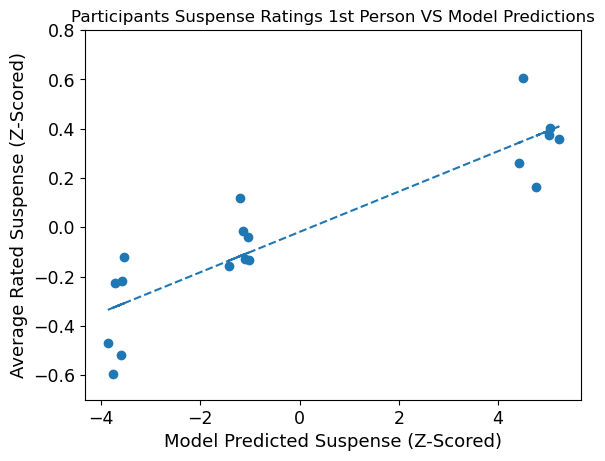

In [77]:
#extract average suspense per game as rated by participants
avg_susp_per_game = susp_filtered_df.groupby(['game'])['susp_rating'].mean()


#Calculate sum of Z-scored suspense model data
model_susp_zscored_sum = np.sum(model_susp_zscored, axis = 1)

#find line of best fit
a, b = np.polyfit(model_susp_zscored_sum, avg_susp_per_game, 1)

plt.scatter(model_susp_zscored_sum, avg_susp_per_game)
plt.plot(model_susp_zscored_sum, a*model_susp_zscored_sum+b, '--')
plt.ylabel('Average Rated Suspense (Z-Scored)', fontsize = '13')
plt.xlabel('Model Predicted Suspense (Z-Scored)', fontsize = '13')
plt.title('Participants Suspense Ratings 1st Person VS Model Predictions')
plt.ylim(-0.7,0.8)
plt.yticks(fontsize = '12.5')
plt.xticks(fontsize = '12.5')


#Calculate correlation:

# Create a DataFrame
df = pd.DataFrame({'Model Suspense': model_susp_zscored_sum, 'Average Suspense': avg_susp_per_game})

# Calculate Pearson correlation
pearson_correlation = df['Model Suspense'].corr(df['Average Suspense'])
print("Pearson Correlation:", pearson_correlation)




In [78]:
model_susp_zscored_sum

array([-3.86450689, -3.60019965, -3.76498602, -3.53781881, -3.58757925,
       -3.72820657, -1.14463027, -1.03212841, -1.42840899, -1.09667275,
       -1.19835712, -1.02311384,  4.50245813,  4.41988465,  5.22398446,
        5.04874118,  4.77577995,  5.0357602 ])

In [79]:
# Get unique participant IDs
participants = susp_filtered_df['participant'].unique()

# Create a dictionary to store DataFrames for each participant
participant_dfs = {}

# Iterate over each participant
for participant in participants:
    # Filter data for the current participant
    participant_df = susp_filtered_df[susp_filtered_df['participant'] == participant].copy()
    
    # Store the DataFrame for the current participant in the dictionary
    participant_dfs[participant] = participant_df

In [80]:
#Compute linear model comparing suspense ratings given by participants and model

# Create a dictionary to store DataFrames for each participant
participant_models = {}
participant_param = {}

#first compute 17 different models (1 per participant)
for participant in participant_dfs:
    #extract suspense rating per participant for each round per game
    participant_sum_susp = participant_dfs[participant].groupby(['game'])['susp_rating'].sum()

    X = model_susp_zscored_sum
    # Add a column of ones to the independent variables matrix (required for the intercept)
    X_with_intercept = sm.add_constant(X)
    
    y = participant_sum_susp

    # Create and fit the linear regression model
    model_susp_1st_part = sm.OLS(y, X_with_intercept).fit()

    # Save model results to a file to compare with other model
    model_susp_1st = {
        "params": model_susp_1st_part.params.tolist(),
        "llf": model_susp_1st_part.llf,
        "aic": model_susp_1st_part.aic,
        "bic": model_susp_1st_part.bic,
        "std_err": model_susp_1st_part.bse.tolist()
    }


    participant_models[participant] = model_susp_1st_part
    participant_param[participant] = model_susp_1st




In [89]:

all_r_squared =[]

for participant in participant_models:
    r_squared = participant_models[participant].rsquared
    all_r_squared.append(r_squared)

mean_r_squared = np.mean(all_r_squared)

print(mean_r_squared)


0.35951975232391126


Average Constant: -0.09490448945209472
Average Slope: 0.4092788045380069
Average Standard Error for Constants: 0.6159895568221113
Average Standard Error for Slopes: 0.17224423648204415
Final Equation: y = 0.4092788045380069*x + -0.09490448945209472


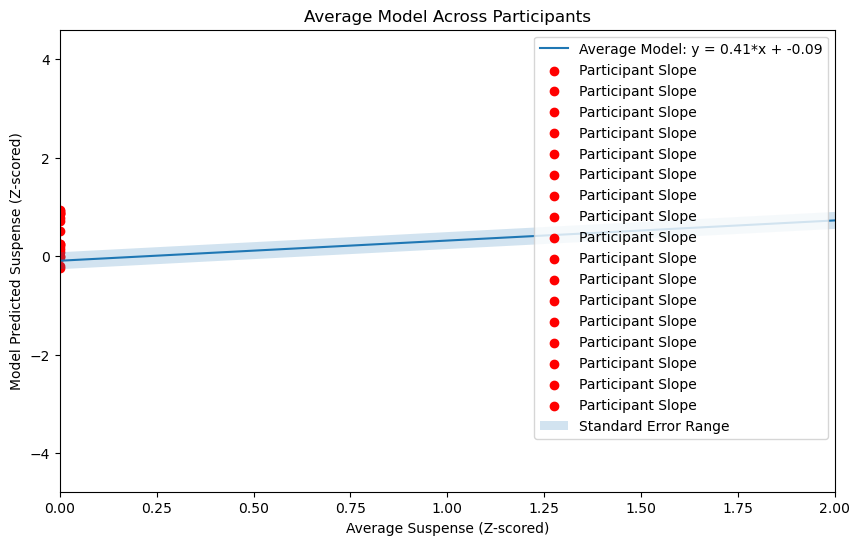

In [82]:


# Initialize lists to store parameters
constants = []
slopes = []
stderr_const = []
stderr_slopes = []

for participant in participant_param:
    parameters = participant_param[participant]['params']
    std = participant_param[participant]['std_err']
    constants.append(parameters[0])
    slopes.append(parameters[1])
    stderr_const.append(std[0])
    stderr_slopes.append(std[1])

avg_constant = sum(constants) / len(constants)
avg_slope = sum(slopes) / len(slopes)
avg_stderr_const = sum(stderr_const) / len(stderr_const)
avg_stderr_slopes = sum(stderr_slopes) / len(stderr_slopes)

# Print the average constant and slope
print("Average Constant:", avg_constant)
print("Average Slope:", avg_slope)
print("Average Standard Error for Constants:", avg_stderr_const)
print("Average Standard Error for Slopes:", avg_stderr_slopes)

# Construct the equation y = mx + b
print(f"Final Equation: y = {avg_slope}*x + {avg_constant}")

# Create sample x data
x = np.linspace(-10, 10, 100)
y = avg_slope * x + avg_constant

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'Average Model: y = {avg_slope:.2f}*x + {avg_constant:.2f}')

# Plot each participant's slope as a dot
for participant in participant_param:
    participant_slope = participant_param[participant]['params'][1]
    plt.scatter(0, participant_slope, color='red', marker='o', label='Participant Slope')


plt.fill_between(x, y - avg_stderr_slopes, y + avg_stderr_slopes, alpha=0.2, label='Standard Error Range')
plt.xlabel('Average Suspense (Z-scored)')
plt.ylabel('Model Predicted Suspense (Z-scored)')
plt.title('Average Model Across Participants')
plt.legend()
plt.xlim(0,2)
#plt.grid(True)

# Ensure the plot displays the intersection with the y-axis
plt.xlim(left=0)

plt.show()


In [83]:
#Now check if there are statistical differences between a distribution of slopes centred around 0 and the distribution of slopes in our data
all_slopes = []
for participant in participant_param:
    slope = participant_param[participant]['params'][1]
    all_slopes.append(slope)



#Compare to null distribution
n_participants = len(all_slopes)
null_distrib = np.random.randn(100000)


#save slopes from 1st person to compare with model of 3rd person

with open('all_slopes_1st.json', 'w') as f:
    json.dump(all_slopes, f)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


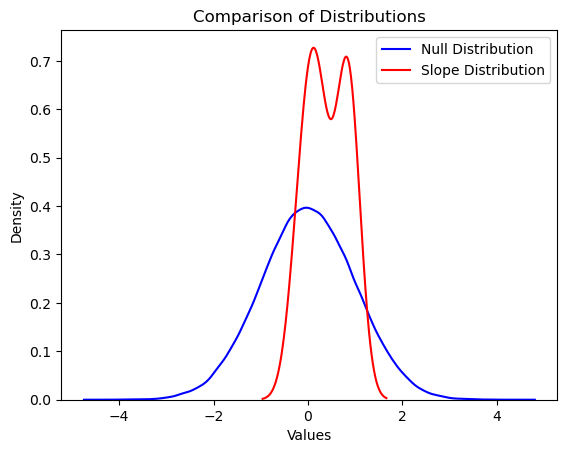

In [84]:
# Plot the KDE curve for null distribution
sns.kdeplot(null_distrib, color='blue', label='Null Distribution')

# Plot the KDE curve for distribution of slopes
sns.kdeplot(all_slopes, color='red', label='Slope Distribution')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Comparison of Distributions')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [85]:
from scipy import stats

In [86]:
t_statistic, p_value = stats.ttest_1samp(all_slopes, 0)
# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the slopes and the null distribution.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the slopes and the null distribution.")

T-statistic: 3.9980371019805236
P-value: 0.0010362926802473258
Reject the null hypothesis: There is a significant difference between the slopes and the null distribution.


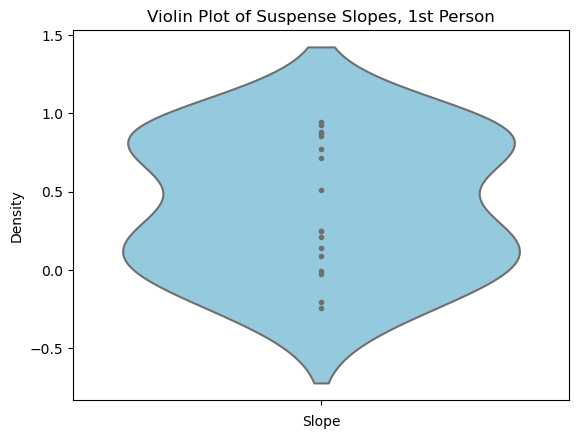

In [87]:
#Make violin plot:

# Convert list to DataFrame
df = pd.DataFrame(all_slopes, columns=['Slope'])


# Create the violin plot
sns.violinplot(y='Slope', data=df, palette=sns.color_palette(['skyblue']), inner='point', facecolor='skyblue', alpha=0.001)


# Add title and labels
plt.title('Violin Plot of Suspense Slopes, 1st Person')
plt.xlabel('Slope')
plt.ylabel('Density')

# Show the plot
plt.show()